# Bitcoin and random forests
## Trying to generate a sensible dependent value. 

The goal of this notebook is to think about a binary dependent variable and employ a random forest. 

First, the following metrics are going to be calculated: 
 - 20 candle moving average
 - volume weighted price
 - monthly, weekly, daily levels

Afterwards, think of a good dependent variable. 

In [1]:
# import data from septembre of 2022 since it was rather stable during this period
import pandas as pd

# data are 15 minute candlesticks
df = pd.read_csv("btc-data/BTCUSDT_15_2023-09-01_2023-09-30.csv", names=["time","open","high","low","close","vol"], header=None)

# if on kaggle:
# df = pd.read_csv("/kaggle/input/btcusdt-15-2023-09-01-2023-09-30/BTCUSDT_15_2023-09-01_2023-09-30.csv", names=["time","open","high","low","close","vol"], header=None)

print(df.shape)
df.head(3)

(2881, 6)


,time,open,high,low,close,vol
0,2023.09.01 00:00,26009.3,26016.5,25627.2,25856.8,20063.967
1,2023.09.01 00:15,25856.8,26021.2,25840.1,25910.7,5158.731
2,2023.09.01 00:30,25910.7,25955.9,25888.7,25945.7,1300.917


In [23]:
# transform to date_time
df["time"] = pd.to_datetime(df["time"])

# Extracting day and hour
df["day"] = df["time"].dt.day
df["hour"] = df["time"].dt.hour

# the 10-day moving average
df["10MA"] = df["close"].rolling(window=10).mean()

# Calculate the standard deviation of the closing prices over the same 20-day period
df["10STD"] = df["close"].rolling(window=10).std()

# volume weighted close price
df["vwap"] = df.close/df.vol

# Bollinger Band: 
# simple_moving_average(20) + std x 2 | sma - std x 2
df["bb_upper_band"] = df["10MA"] + 2 * df["10STD"]
df["bb_lower_band"] = df["10MA"] - 2 * df["10STD"]

# daily_open
df["daily_open"] = df.groupby(df["day"])["open"].transform("first")

# daily_close
df["daily_close"] = df.groupby(df["day"])["close"].transform("first")


# Calculate On-Balance Volume (OBV)
df["change"] = df["close"].diff()
df["direction"] = df["change"].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
df["obv"] = df["vol"] * df["direction"]
df["obv"] = df["obv"].cumsum()

# define variables that look 1 to three periods into the future
df["open_p1"] = df["open"].shift(1)
df["high_p1"] = df["high"].shift(1)
df["low_p1"] = df["low"].shift(1)
df["close_p1"] = df["close"].shift(1)

df["open_p2"] = df["open"].shift(2)
df["high_p2"] = df["high"].shift(2)
df["low_p2"] = df["low"].shift(2)
df["close_p2"] = df["close"].shift(2)

df["open_p3"] = df["open"].shift(3)
df["high_p3"] = df["high"].shift(3)
df["low_p3"] = df["low"].shift(3)
df["close_p3"] = df["close"].shift(3)


print(df.shape)
df[18:].head(3) # data set starts with the 20th observation since the first 20 rows had to be used for the moving average

(2881, 37)


,time,open,high,low,close,vol,vol_close,day,hour,20MA,...,low_p1,close_p1,open_p2,high_p2,low_p2,close_p2,open_p3,high_p3,low_p3,close_p3
18,2023-09-01 04:30:00,25987.5,25989.7,25963.2,25975.2,271.451,95.690198,1,4,NaN,...,25976.4,25987.5,26038.2,26041.9,25993.0,26011.5,26024.6,26045.8,26016.7,26038.2
19,2023-09-01 04:45:00,25975.2,25987.0,25961.5,25972.2,267.663,97.033210,1,4,25976.945,...,25963.2,25975.2,26011.5,26011.6,25976.4,25987.5,26038.2,26041.9,25993.0,26011.5
20,2023-09-01 05:00:00,25972.2,26000.0,25972.1,25980.9,249.057,104.317084,1,5,25983.150,...,25961.5,25972.2,25987.5,25989.7,25963.2,25975.2,26011.5,26011.6,25976.4,25987.5


# Dependent variable 

Now it is time to think about a dependent variable. 

First, I would like to try a binary variable which incorporates something with a moving averge kind of thing. 

Therefore: If the price is out of the Bollinger Bands, has the following candle [=some price in the range from high to low] a price that is at least 0.5% away from the value of the Bollinger Band value? 

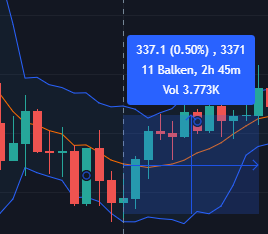

In [17]:
from IPython.display import Image
Image(filename="dep_var1.png") 

In [ ]:
# if the price is outside of the bollinger bands: 
#    is the next candle 0.5% away from the bb value?